# Parameter Efficient Fine Tuning with PEFT Library

https://huggingface.co/docs/peft

As it is said in the docs:

🤗 PEFT, or Parameter-Efficient Fine-Tuning (PEFT), is a library for efficiently adapting pre-trained language models (PLMs) to various downstream applications without fine-tuning all the model’s parameters. PEFT methods only fine-tune a small number of (extra) model parameters, significantly decreasing computational and storage costs because fine-tuning large-scale PLMs is prohibitively costly. Recent state-of-the-art PEFT techniques achieve performance comparable to that of full fine-tuning.

In [ ]:
!pip install transformers==4.24.0
!pip install Pillow==10.0.0
!pip install -U sentence-transformers==2.2.2
!pip install datasets==2.14.4
!pip install sentencepiece==0.1.99
!pip install peft==0.5.0

In [ ]:
from torch.optim import AdamW
from torch.utils.data import DataLoader
from peft import get_peft_model, LoraConfig, TaskType

from datasets import load_dataset
from transformers import AutoModelForSequenceClassification

from datasets import load_dataset
import transformers
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from google.colab import drive
from PIL import Image

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


### PEFT config with LoRA https://arxiv.org/abs/2106.09685

Answer the following questions:
* What is LORA? Is PEFT only about LORA?
* Whats does param ```r``` in lora config mean? What are values worth trying for this param?
* What does ```lora_alpha``` in lora config mean? What are values worth trying for this param?
* Why we initialise config with ```inference_model = False```? How to use this param?

Read more in the docs https://huggingface.co/docs/peft/conceptual_guides/lora

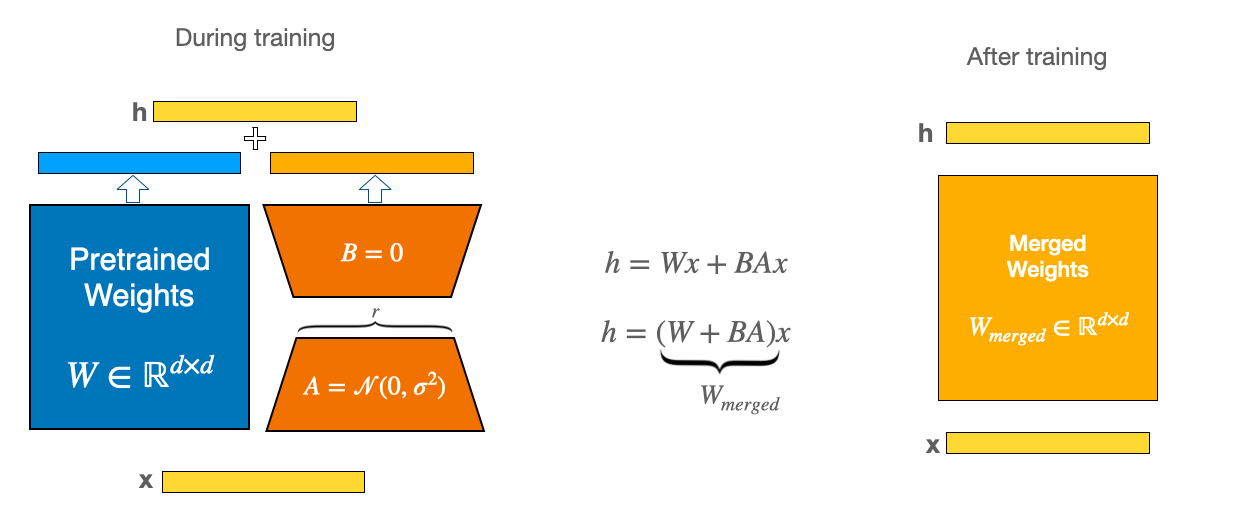

In [ ]:
Image.open("/content/drive/MyDrive/oxford_llms_practice/day_2/images/lora.png")

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
)

Once we initialised our peft config, we need to load a pretrained model that we are going to fine tune and wrap the model into peft model. We will use ```get_peft_model``` method from PEFT for this.

In [ ]:
model_name = "roberta-large"

model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
config = transformers.AutoConfig.from_pretrained(model_name)


model = get_peft_model(model, peft_config)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should 

We now see our model is wrappend into ```PeftModelForSequenceClassification``` |and ```LoraModel``` classes.

Read more https://huggingface.co/docs/peft/package_reference/peft_model#peft.PeftModelForSequenceClassification

In [ ]:
model

Lets see how PEFT helps to optimize fine tuning. We will print number of trainable parameters for initial model and for PEFT model.

We see that PEFT will use only 2,889,732 out of 357,199,876 for fine tuning. This is less than 1% of all params!

In [ ]:
model.print_trainable_parameters()

trainable params: 2,889,732 || all params: 357,199,876 || trainable%: 0.8089958015550934


# Example fine tuning with PEFT

# imdb sentiment analys

Previously we saw how to fine tune sentiment classification model on the imdb dataaset. We used tiny distillbert model to fit memory requirements. This time we will see how PEFT may help to fine tune large models using same amount of memory (or even less).

The dataset: https://huggingface.co/datasets/imdb is a collection of reviews from imdb website labelled with positive or negative sentiment.

In [ ]:
imdb = load_dataset("imdb", split="test")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
imdb_df = imdb.to_pandas()

In [ ]:
imdb_df.head()

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0


In [ ]:
imdb_sample = imdb_df.sample(n=1000, random_state=2023)

In [ ]:
imdb_sample["label"].value_counts()

1    529
0    471
Name: label, dtype: int64

In [ ]:
class ExampleDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(label, dtype=torch.long),
        }

In [ ]:
### Fine tune your model

imdb_train = load_dataset("imdb", split="train")

In [ ]:
imdb_train_sample = imdb_train.to_pandas().sample(n=5000, random_state=2023)

In [ ]:
train_dataset = ExampleDataset(
    texts=imdb_train_sample["text"].tolist(),
    labels=imdb_train_sample["label"].tolist(),
    tokenizer=tokenizer,
    max_length=512,
)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False)

In [ ]:
def train(model, train_loader, num_epochs=1, learning_rate=2e-5, device="cuda"):
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {average_loss:.4f}")

    print("Training complete!")

In [ ]:
train(model, train_dataloader)

Epoch 1/1 - Average Loss: 0.3446
Training complete!


In [ ]:
def evaluate(model, dataloader, device="cuda"):
    model.eval()
    model.to(device)

    valid_preds, valid_labels = [], []

    for batch in dataloader:
        b_input_ids = batch["input_ids"].to(device)
        b_input_mask = batch["attention_mask"].to(device)
        b_labels = batch["label"].to(device)

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_input_mask)

        logits = logits[0].detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()

        batch_preds = np.argmax(logits, axis=1)
        batch_labels = np.concatenate(label_ids.reshape(-1, 1))
        valid_preds.extend(batch_preds)
        valid_labels.extend(batch_labels)

    return valid_labels, valid_preds

In [ ]:
val_dataset = ExampleDataset(
    texts=imdb_sample["text"].tolist(),
    labels=imdb_sample["label"].tolist(),
    tokenizer=tokenizer,
    max_length=512,
)

val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
valid_labels, valid_preds = evaluate(model, val_dataloader)

from sklearn.metrics import f1_score

f1_score(valid_labels, valid_preds)

0.9626078619367211

# To sum up:
* We see that PEFT may be helpful it you need to finetune a large model that doesnt fit your memory requirements.
* Remember that before using PEFT with very large models, think if you really need such a large model. Probably your task may be solved by a smaller model or maybe a model fine tuned on the domain of your interest does exsists (check HF models space for this).